# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/viktor/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 11, 39, 23, 992741)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 11:39:29,044 INFO: Initializing external client
2025-11-18 11:39:29,045 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 11:39:29,922 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 11:39:30,541 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296538


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

"""retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)"""
#Replaced for C-part!
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_lag",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 11:39:43,981 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/459200 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115899 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27232 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.7046219E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
def forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags):
    rows = rows_to_predict.sort_values("date").reset_index(drop=True).copy()
    predictions = []
    
    if use_lags: #establish a starting point (today!): 
        lag_1 = row_today['pm25']
        lag_2 = row_today['pm25_lag1']
        lag_3 = row_today['pm25_lag2']

    max_horizon = min(max_horizon, len(rows)) #just in case i send in something weird later!
    
    for h in range(max_horizon): #from tomorrow onwards: 
        idx = rows.index[h]
        
        if use_lags: #overwrite possible real values (which is illegal to use here) with predicted values!
            rows.at[idx, "pm25_lag1"] = lag_1
            rows.at[idx, "pm25_lag2"] = lag_2
            rows.at[idx, "pm25_lag3"] = lag_3
            
        X_row = rows.loc[idx, feature_cols].values.reshape(1, -1)
        
        y_pred = float(model.predict(X_row)[0])

        predictions.append(y_pred)
        if use_lags:
            #push all lags back because we move forward one day:
            lag_3 = lag_2 
            lag_2 = lag_1
            lag_1 = y_pred

        
    return predictions, rows

"""def forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags):
    predictions = []
    
    if use_lags: #establish a starting point (today!): 
        lag_1 = row_today['pm25']
        lag_2 = row_today['pm25_lag1']
        lag_3 = row_today['pm25_lag2']
        
    for h in range(max_horizon): #from tomorrow onwards: 
        row_to_predict = rows_to_predict.iloc[h].copy()
        
        if use_lags: #overwrite possible real values (which is illegal to use here) with predicted values!
            row_to_predict['pm25_lag1'] = lag_1
            row_to_predict['pm25_lag2'] = lag_2
            row_to_predict['pm25_lag3'] = lag_3
            
        X_row = row_to_predict[feature_cols].values.reshape(1, -1)
        y_pred = float(model.predict(X_row)[0])

        predictions.append(y_pred)
        if use_lags:
            #push all lags back because we move forward one day:
            lag_3 = lag_2 
            lag_2 = lag_1
            lag_1 = y_pred

        
    return predictions"""


"def forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags):\n    predictions = []\n    \n    if use_lags: #establish a starting point (today!): \n        lag_1 = row_today['pm25']\n        lag_2 = row_today['pm25_lag1']\n        lag_3 = row_today['pm25_lag2']\n        \n    for h in range(max_horizon): #from tomorrow onwards: \n        row_to_predict = rows_to_predict.iloc[h].copy()\n        \n        if use_lags: #overwrite possible real values (which is illegal to use here) with predicted values!\n            row_to_predict['pm25_lag1'] = lag_1\n            row_to_predict['pm25_lag2'] = lag_2\n            row_to_predict['pm25_lag3'] = lag_3\n            \n        X_row = row_to_predict[feature_cols].values.reshape(1, -1)\n        y_pred = float(model.predict(X_row)[0])\n\n        predictions.append(y_pred)\n        if use_lags:\n            #push all lags back because we move forward one day:\n            lag_3 = lag_2 \n            lag_2 = lag_1\

In [8]:
#Get the feature group for the lags:

#first just get feature_cols (which features the model expects):
X_sample = fv.get_batch_data()
if "pm25" in X_sample.columns:
    X_sample = X_sample.drop(columns=['pm25'])
X_sample = X_sample.drop(columns=['date'])  #model does not expect a date.
feature_cols = list(X_sample.columns)

air_quality_fg_v2 = fs.get_feature_group(
    name="air_quality",
    version=2,
)
#We are just interested in today's values (or at least, the latest value if today data does not exist!):

history = air_quality_fg_v2.read()
sensor_history = history.query("country == @country and city == @city and street == @street").copy()

sensor_history["date"] = pd.to_datetime(sensor_history["date"])  #ensure correct format

sensor_history = sensor_history.sort_values("date")

row_today = sensor_history.iloc[-1]
row_today

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.59s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 


date                  2025-11-18 00:00:00+00:00
pm25                                       10.0
country                                  sweden
city                                  linkoping
street                             hamngatan-10
url          https://api.waqi.info/feed/@13990/
pm25_lag1                                  10.0
pm25_lag2                                  17.0
pm25_lag3                                  12.0
Name: 1152, dtype: object

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [9]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()

#Additions C-part:
batch_data = batch_data.sort_values("date").reset_index(drop=True)

#C-part, want to add empty 
import numpy as np

batch_data = batch_data.copy()   #probably not nessecary, but for paranoia
batch_data["pm25_lag1"] = np.nan
batch_data["pm25_lag2"] = np.nan
batch_data["pm25_lag3"] = np.nan

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3
0,2025-11-19 00:00:00+00:00,-0.75,0.0,9.746631,85.763687,linkoping,NaN,NaN,NaN
1,2025-11-20 00:00:00+00:00,-2.15,0.4,19.803272,358.958405,linkoping,NaN,NaN,NaN
2,2025-11-21 00:00:00+00:00,-3.00,0.0,9.885262,280.491425,linkoping,NaN,NaN,NaN
3,2025-11-22 00:00:00+00:00,2.40,0.0,15.077082,236.689362,linkoping,NaN,NaN,NaN
4,2025-11-23 00:00:00+00:00,2.20,0.3,4.024922,243.435013,linkoping,NaN,NaN,NaN
5,2025-11-24 00:00:00+00:00,2.40,0.0,15.188416,31.429514,linkoping,NaN,NaN,NaN
6,2025-11-25 00:00:00+00:00,-0.70,0.0,12.181625,18.970512,linkoping,NaN,NaN,NaN
7,2025-11-26 00:00:00+00:00,-1.15,0.0,11.298495,30.650600,linkoping,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
"""batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data"""
use_lags = True
predicitons, batch_data = forecast_recursive(retrieved_xgboost_model, row_today, batch_data, feature_cols, len(batch_data), use_lags)

batch_data["predicted_pm25"] = predicitons
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25
0,2025-11-19 00:00:00+00:00,-0.75,0.0,9.746631,85.763687,linkoping,10.000000,10.000000,17.000000,20.364059
1,2025-11-20 00:00:00+00:00,-2.15,0.4,19.803272,358.958405,linkoping,20.364059,10.000000,10.000000,17.027493
2,2025-11-21 00:00:00+00:00,-3.00,0.0,9.885262,280.491425,linkoping,17.027493,20.364059,10.000000,32.818600
3,2025-11-22 00:00:00+00:00,2.40,0.0,15.077082,236.689362,linkoping,32.818600,17.027493,20.364059,43.690758
4,2025-11-23 00:00:00+00:00,2.20,0.3,4.024922,243.435013,linkoping,43.690758,32.818600,17.027493,39.569103
5,2025-11-24 00:00:00+00:00,2.40,0.0,15.188416,31.429514,linkoping,39.569103,43.690758,32.818600,19.963781
6,2025-11-25 00:00:00+00:00,-0.70,0.0,12.181625,18.970512,linkoping,19.963781,39.569103,43.690758,15.337465
7,2025-11-26 00:00:00+00:00,-1.15,0.0,11.298495,30.650600,linkoping,15.337465,19.963781,39.569103,26.079466


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         8 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          8 non-null      float32                
 2   precipitation_sum            8 non-null      float32                
 3   wind_speed_10m_max           8 non-null      float32                
 4   wind_direction_10m_dominant  8 non-null      float32                
 5   city                         8 non-null      object                 
 6   pm25_lag1                    8 non-null      float64                
 7   pm25_lag2                    8 non-null      float64                
 8   pm25_lag3                    8 non-null      float64                
 9   predicted_pm25               8 non-null      float64                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-0.75,0.0,9.746631,85.763687,linkoping,10.000000,10.000000,17.000000,20.364059,hamngatan-10,sweden,1
1,2025-11-20 00:00:00+00:00,-2.15,0.4,19.803272,358.958405,linkoping,20.364059,10.000000,10.000000,17.027493,hamngatan-10,sweden,2
2,2025-11-21 00:00:00+00:00,-3.00,0.0,9.885262,280.491425,linkoping,17.027493,20.364059,10.000000,32.818600,hamngatan-10,sweden,3
3,2025-11-22 00:00:00+00:00,2.40,0.0,15.077082,236.689362,linkoping,32.818600,17.027493,20.364059,43.690758,hamngatan-10,sweden,4
4,2025-11-23 00:00:00+00:00,2.20,0.3,4.024922,243.435013,linkoping,43.690758,32.818600,17.027493,39.569103,hamngatan-10,sweden,5
5,2025-11-24 00:00:00+00:00,2.40,0.0,15.188416,31.429514,linkoping,39.569103,43.690758,32.818600,19.963781,hamngatan-10,sweden,6
6,2025-11-25 00:00:00+00:00,-0.70,0.0,12.181625,18.970512,linkoping,19.963781,39.569103,43.690758,15.337465,hamngatan-10,sweden,7
7,2025-11-26 00:00:00+00:00,-1.15,0.0,11.298495,30.650600,linkoping,15.337465,19.963781,39.569103,26.079466,hamngatan-10,sweden,8


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         8 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          8 non-null      float32                
 2   precipitation_sum            8 non-null      float32                
 3   wind_speed_10m_max           8 non-null      float32                
 4   wind_direction_10m_dominant  8 non-null      float32                
 5   city                         8 non-null      object                 
 6   pm25_lag1                    8 non-null      float64                
 7   pm25_lag2                    8 non-null      float64                
 8   pm25_lag3                    8 non-null      float64                
 9   predicted_pm25               8 non-null      float64                
 10  street

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 11:42:59,532 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



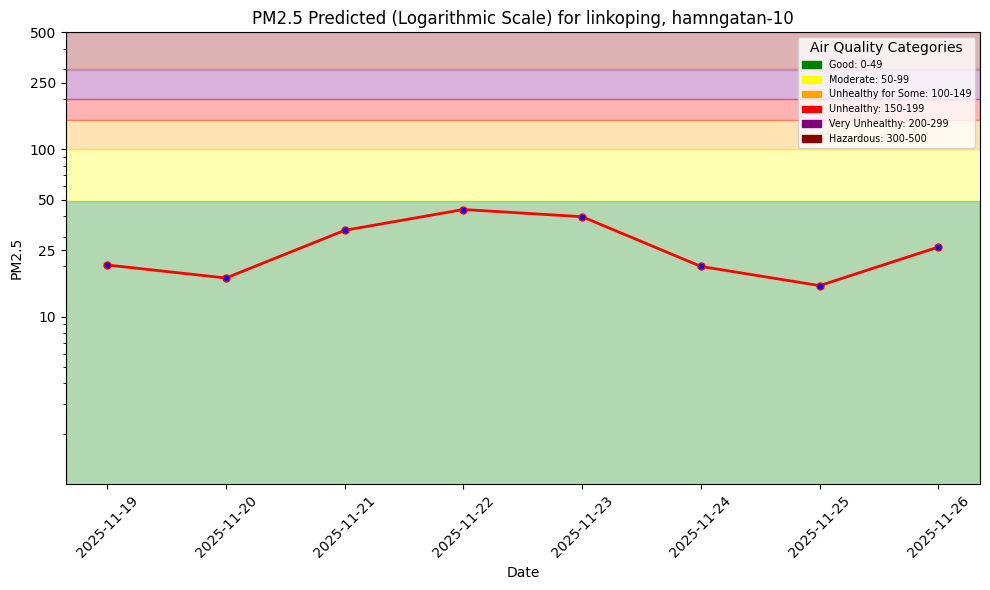

In [14]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [15]:
# Get or create feature group               MAY HAVE TO CHANGE THIS TO VERSION 2. 
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,   #Changed from version 1 to 2 for C-part
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [16]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 8/8 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296538/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-18 11:43:26,254 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 11:43:29,403 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:44:57,970 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:44:58,124 INFO: Waiting for log aggregation to finish.
2025-11-18 11:45:06,640 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-0.750000,0.000000,9.746631,85.763687,linkoping,10.0,10.0,17.0,20.364059,hamngatan-10,sweden,1
1,2025-11-14 00:00:00+00:00,3.950000,0.000000,18.089775,275.710510,linkoping,6.0,18.0,18.0,12.202303,hamngatan-10,sweden,1
2,2025-11-16 00:00:00+00:00,4.050000,0.000000,14.917212,250.253067,linkoping,22.0,12.0,8.0,28.187422,hamngatan-10,sweden,1
3,2025-11-17 00:00:00+00:00,0.600000,0.000000,10.195057,312.137512,linkoping,17.0,12.0,8.0,24.363207,hamngatan-10,sweden,1
4,2025-11-18 00:00:00+00:00,1.500000,0.000000,5.351785,312.273621,linkoping,10.0,17.0,12.0,11.558299,hamngatan-10,sweden,1
5,2025-11-15 00:00:00+00:00,2.650000,0.000000,16.167967,258.439911,linkoping,8.0,6.0,18.0,14.490637,hamngatan-10,sweden,1
6,2025-11-10 00:00:00+00:00,6.761335,0.400000,9.096681,229.367889,linkoping,40.0,61.0,43.0,43.882526,hamngatan-10,sweden,1
7,2025-11-12 00:00:00+00:00,8.838416,8.300000,27.837219,204.005066,linkoping,18.0,28.0,40.0,22.964220,hamngatan-10,sweden,1
8,2025-11-09 00:00:00+00:00,6.082167,0.000000,12.811650,237.230606,linkoping,61.0,43.0,28.0,47.205444,hamngatan-10,sweden,1
9,2025-11-13 00:00:00+00:00,7.802999,8.099999,25.779619,263.906311,linkoping,18.0,18.0,28.0,19.402664,hamngatan-10,sweden,1


In [18]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)   #changed from version 1 to version 2 for C-part
air_quality_df = air_quality_fg.read()
air_quality_df = air_quality_df.sort_values("date").reset_index(drop=True)
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3
0,2022-09-05 00:00:00+00:00,12.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,11.0,7.0,12.0
1,2022-09-06 00:00:00+00:00,14.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,12.0,11.0,7.0
2,2022-09-07 00:00:00+00:00,14.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,14.0,12.0,11.0
3,2022-09-08 00:00:00+00:00,9.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,14.0,14.0,12.0
4,2022-09-09 00:00:00+00:00,19.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,9.0,14.0,14.0
...,...,...,...,...,...,...,...,...,...
1148,2025-11-14 00:00:00+00:00,8.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,6.0,18.0,18.0
1149,2025-11-15 00:00:00+00:00,12.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,8.0,6.0,18.0
1150,2025-11-16 00:00:00+00:00,17.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,22.0,12.0,8.0
1151,2025-11-17 00:00:00+00:00,10.0,sweden,linkoping,hamngatan-10,https://api.waqi.info/feed/@13990/,17.0,12.0,8.0


In [19]:
def backfill_predictions_for_monitoring_lag_model(weather_fg, air_quality_df_v2, monitor_fg, model, feature_cols, country, city, street):
    features_df = weather_fg.read()
    features_df["date"] = pd.to_datetime(features_df["date"])
    features_df = features_df.sort_values(by=['date'], ascending=True)
    
    sensor_history = air_quality_df_v2.query("country == @country and city == @city and street == @street").copy()
    sensor_history["date"] = pd.to_datetime(sensor_history["date"])

    sensor_history = sensor_history[["date", "pm25", "pm25_lag1", "pm25_lag2", "pm25_lag3"]] 
    features_df = pd.merge(
        features_df,
        sensor_history,
        on="date",
        how="inner",   #only keep dataes both have (but it shouldnt be a problem)
    )

    features_df = features_df.sort_values("date")
    features_df = features_df.tail(10)

    features_df = features_df.dropna(subset=["pm25_lag1", "pm25_lag2", "pm25_lag3"])  #should not be any, but just in case
    
    features_df["predicted_pm25"] = model.predict(features_df[feature_cols])
    for col in ["pm25_lag1", "pm25_lag2", "pm25_lag3", "predicted_pm25"]:
        features_df[col] = features_df[col].astype("float64")
        
    features_df['days_before_forecast_day'] = 1
    features_df['city'] = city
    features_df['country'] = country
    features_df['street'] = street
    
    hindcast_df = features_df.copy()
    features_df = features_df.drop('pm25', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    
    return hindcast_df

In [20]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    hindcast_df = backfill_predictions_for_monitoring_lag_model(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, feature_cols, country, city, street)
hindcast_df

,date,predicted_pm25,pm25
7,2025-11-09 00:00:00+00:00,47.205444,40.0
5,2025-11-10 00:00:00+00:00,43.882526,28.0
9,2025-11-11 00:00:00+00:00,21.189978,18.0
6,2025-11-12 00:00:00+00:00,22.964220,18.0
8,2025-11-13 00:00:00+00:00,19.402664,6.0
0,2025-11-14 00:00:00+00:00,12.202303,8.0
4,2025-11-15 00:00:00+00:00,14.490637,12.0
1,2025-11-16 00:00:00+00:00,28.187422,17.0
2,2025-11-17 00:00:00+00:00,24.363207,10.0
3,2025-11-18 00:00:00+00:00,11.558299,10.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

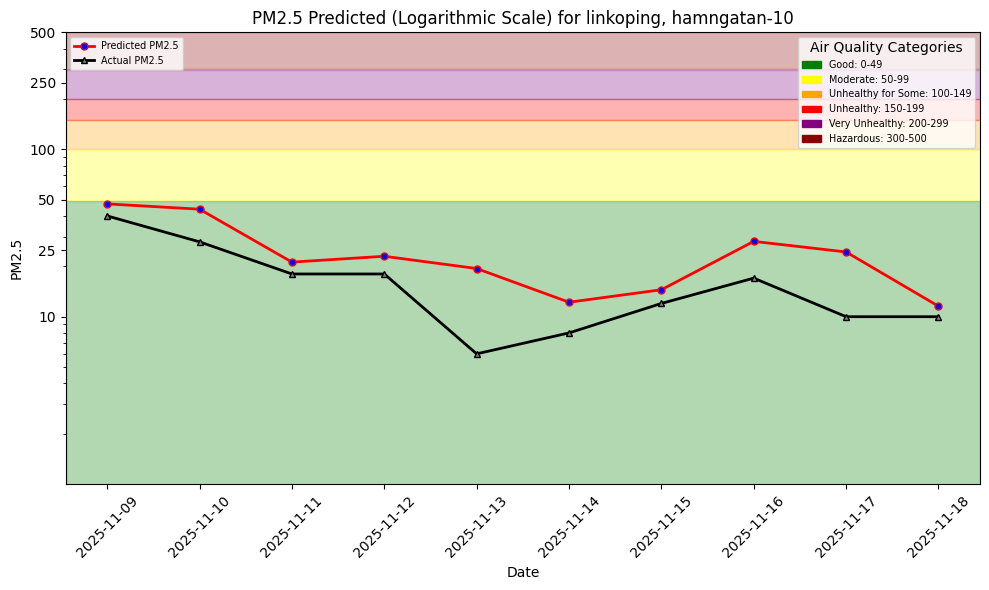

In [21]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [22]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/viktor/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/49052 ela…

Uploading /home/viktor/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | 0/6228…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1296538/settings/fb/path/Resources/airquality


---